In [ ]:
if 'google.colab' in str(get_ipython()):
    import os
    os.system('pip -qqq install ModelFlowIb')
    os.system('curl -L -o yourfile.csv https://raw.githubusercontent.com/OWNER/REPO/BRANCH/path/to/exchangerates_get.csv')


In [8]:
import pandas as pd
import numpy as np

import exchangerates_get as er 

In [2]:
fx_eur = er.ecb_fx_eur(
    currencies=["USD", "GBP", "JPY", "CHF","EUR","ZAR"],
    start="2010-01-01",
    freq='Q'
)
fx_eur    

c:\wb debt simulation\wb-debt-simulation\optimization\exchangerates_get.py:90: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  out = wide.resample(freq).last()


CURRENCY,EUR_CHF,EUR_GBP,EUR_JPY,EUR_USD,EUR_ZAR,EUR_EUR
TIME_PERIOD,,,,,,
2010Q1,1.4276,0.88980,125.93,1.3479,9.8922,1.0
2010Q2,1.3283,0.81745,108.79,1.2271,9.3808,1.0
2010Q3,1.3287,0.85995,113.68,1.3648,9.5438,1.0
2010Q4,1.2504,0.86075,108.65,1.3362,8.8625,1.0
2011Q1,1.3005,0.88370,117.61,1.4207,9.6507,1.0
...,...,...,...,...,...,...
2025Q1,0.9531,0.83536,161.60,1.0815,19.8782,1.0
2025Q2,0.9347,0.85550,169.17,1.1720,20.8411,1.0
2025Q3,0.9364,0.87340,173.76,1.1741,20.2820,1.0


In [3]:
# Step 2: express everything in base currency 
fx_ccy = er.convert_base_currency(fx_eur, base="zar")

fx_returns = er.get_fx_returns(fx_ccy)
# Step 3: yearly covariance matrices
fx_cov = er.get_fx_covariance(fx_returns)

In [14]:
fx_corr = er.get_fx_covariance(fx_returns,correlation=True)
# Example: covariance matrix and standard deviation  
display(fx_cov)
std = np.sqrt(np.diag(fx_cov))
std = pd.Series(std, index=fx_cov.index, name="std")

,ZAR_CHF,ZAR_GBP,ZAR_JPY,ZAR_USD,ZAR_EUR
ZAR_CHF,0.003321,0.002638,0.003144,0.003151,0.002842
ZAR_GBP,0.002638,0.003153,0.002880,0.003084,0.002778
ZAR_JPY,0.003144,0.002880,0.005409,0.003622,0.002880
ZAR_USD,0.003151,0.003084,0.003622,0.004713,0.002952
ZAR_EUR,0.002842,0.002778,0.002880,0.002952,0.003228


ZAR_CHF    5.762589
ZAR_GBP    5.615319
ZAR_JPY    7.354562
ZAR_USD    6.865152
ZAR_EUR    5.681451
Name: std, dtype: float64


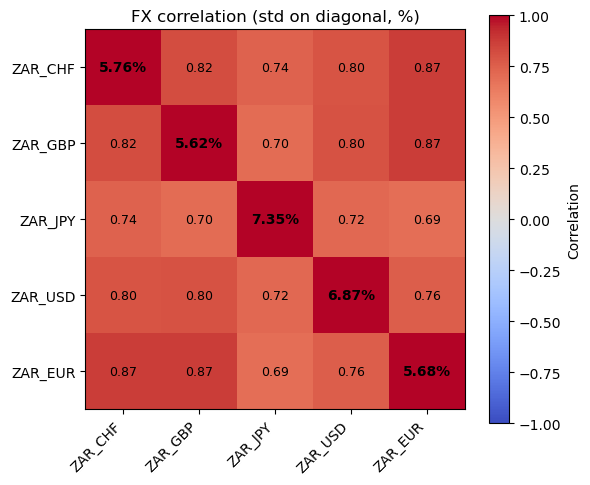

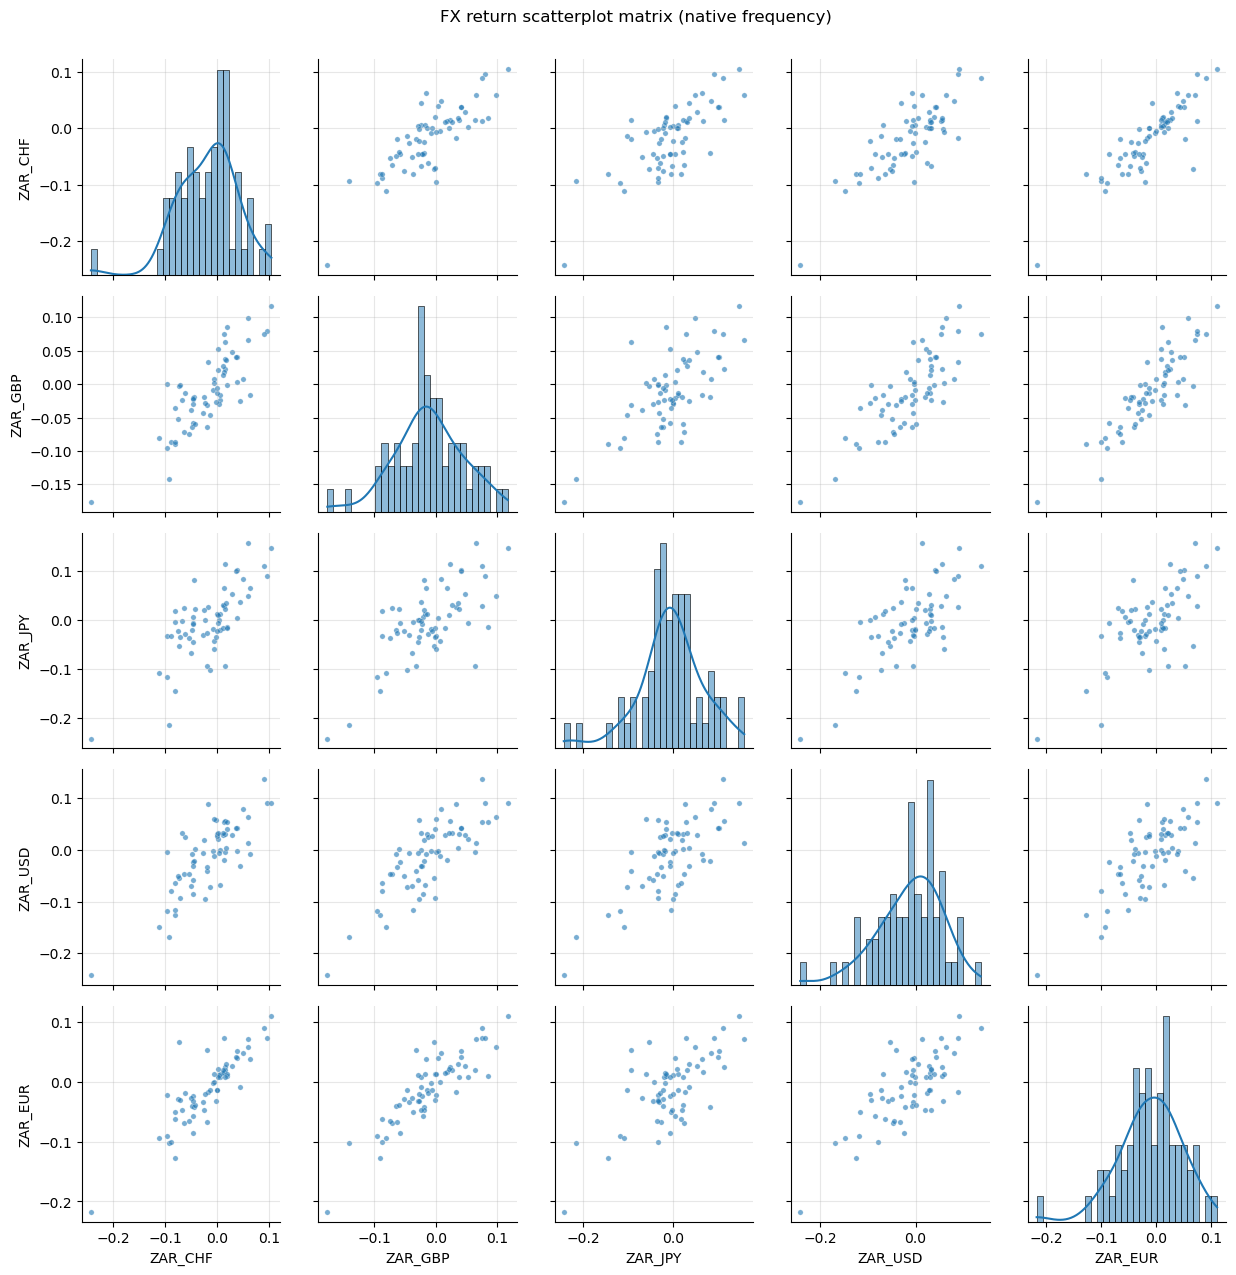

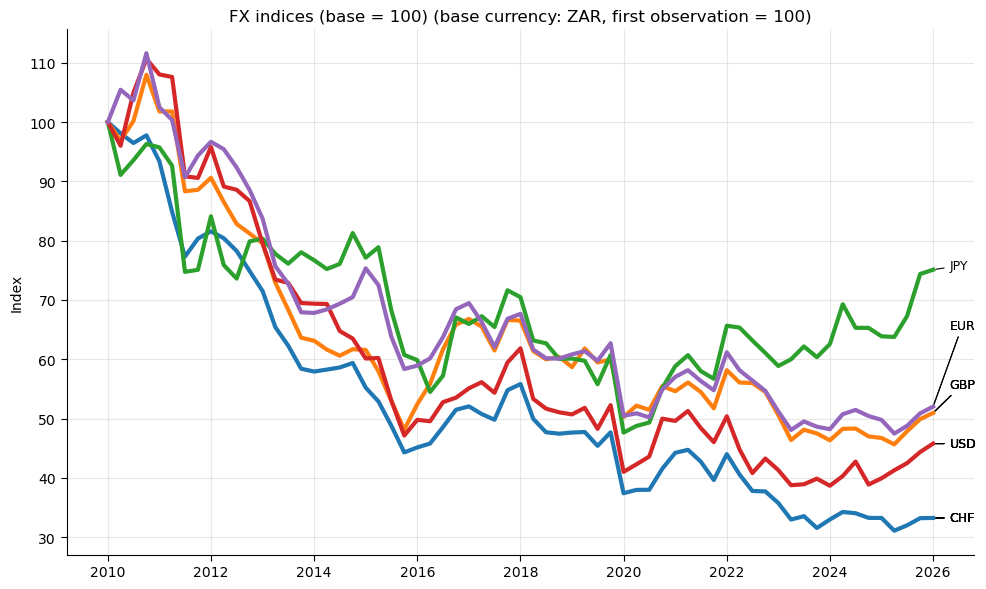

In [9]:
print(std*100)

er.plot_corr_with_std(
    fx_returns,
    title="FX correlation (std on diagonal, %)"
)


er.plot_return_scatter_matrix_with_marginals(
    fx_returns,
    title="FX return scatterplot matrix (native frequency)"
)
#%%
er.plot_indexed_fx(
    fx_ccy,
    min_label_gap=10.0

)

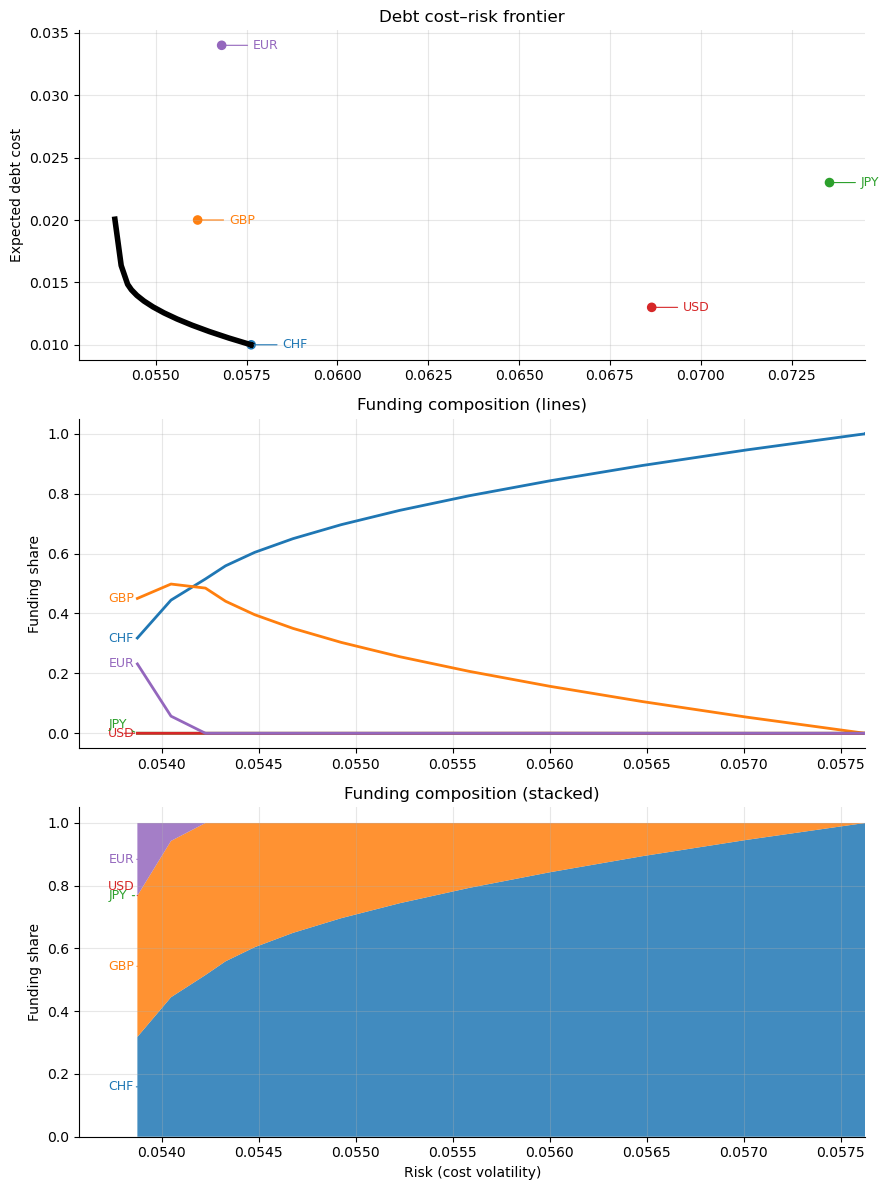

In [18]:
cov_df = fx_cov.rename(
index=lambda x: x.split('_')[1],
columns=lambda x: x.split('_')[1]
 )
names =cov_df.index 

fx_yield = pd.Series([0.01,0.02,0.023,0.013,0.034],index = names)
risk_i = pd.DataFrame(np.sqrt(np.diag(fx_cov.values)),index=fx_yield.index)

risk_return = pd.concat([fx_yield,risk_i],axis=1)
risk_return.columns= ['Yield','risk']
min_s =  pd.Series(0.0,index = names)
max_s =  pd.Series(1.0,index = names)

res = er.mv_frontier_from_dataframes(cov_df=cov_df,ret_s=fx_yield,
           min_s=min_s,max_s=max_s)                       

er.plot_debt_frontier_labeled(
    res,
    label_pos="start",
    cost_col="return",
    cost_s=fx_yield,
    cov_df=cov_df,
    export_path="zar_debt_frontier",
    export_formats=("png", "pdf", "svg")
)

